In [227]:
import os
import pickle
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [228]:
COLORS = [
    "#ffd7b3", # orange
    "#cce1e4", # green
    "#d9d9d9", # grey
    ]

MFE_DICT = {
    "psi_": {"mfe_group": "PsiCalculator*", "proposed_mfe": True},
    "overlap_": {"mfe_group": "OmvPht*", "proposed_mfe": True},
    "omv_pth": {"mfe_group": "OmvPht*", "proposed_mfe": True},
    "dc_accuracy": {"mfe_group": "DomainClassifier*", "proposed_mfe": True},
    "dc_pvalue": {"mfe_group": "DomainClassifier*", "proposed_mfe": True},
    "dc_drift_flag": {"mfe_group": "DomainClassifier*", "proposed_mfe": True},
    "_ks_statistic": {"mfe_group": "SqsiCalculator*", "proposed_mfe": True},
    "_ks_pvalue": {"mfe_group": "SqsiCalculator*", "proposed_mfe": True},
    "sqsi_drift_flag": {"mfe_group": "SqsiCalculator*", "proposed_mfe": True},
    "distance_class_": {"mfe_group": "Udetector*", "proposed_mfe": True},
    "u_detect_drift_flag": {"mfe_group": "Udetector*", "proposed_mfe": True},
    "compacness": {"mfe_group": "ClusteringMetrics", "proposed_mfe": False},
    "kmeans_n_iter": {"mfe_group": "ClusteringMetrics", "proposed_mfe": False},
    "kmeans_n_clusters": {"mfe_group": "ClusteringMetrics", "proposed_mfe": False},
    "kmeans_inertia": {"mfe_group": "ClusteringMetrics", "proposed_mfe": False},
    "_uniqueness_ratio": {"mfe_group": "MiscellaneousMetrics", "proposed_mfe": False},
    "prop_pca": {"mfe_group": "MiscellaneousMetrics", "proposed_mfe": False},
    "_sparsity": {"mfe_group": "MiscellaneousMetrics", "proposed_mfe": False},
    "predict": {"mfe_group": "ScoringMetrics*", "proposed_mfe": True},
    "last": {"mfe_group": "ScoringMetrics*", "proposed_mfe": True},
}

BASE_MODELS = [
    "RandomForestClassifier",
    "SVC",
    "LogisticRegression",
    "DecisionTreeClassifier"
]

METRICS = ["kappa", "precision", "recall", "f1-score"]

COLORS = [
    "#ffd7b3", # orange
    "#cce1e4", # green
    "#A9AFD1", # grey blue
    "#d9d9d9", # grey
    "#E08637", # dark orange
    "#6aa4c8ff", # blue
    "#F5E3AD", # yellow
    "#A2D4B0", # greenn diff
    "#5B919A", # dark green
    ]

DATASETS = [file for file in os.listdir("../../datasets/synthetic/") if ("csv" in file and "friedman" not in file)]
DATASETS

['gradual_agrawal_unbalanced_with_noise.csv',
 'abrupt_recurring_sine_balanced.csv',
 'abrupt_mixed_unbalanced.csv',
 'abrupt_sea.csv',
 'abrupt_sine_unbalanced.csv',
 'abrupt_recurring_sea.csv',
 'abrupt_sine_unbalanced_noise.csv',
 'abrupt_mixed_balanced.csv',
 'abrupt_recurring_stagger_balanced.csv',
 'abrupt_sea_noise.csv',
 'abrupt_recurring_mixed_balanced.csv',
 'abrupt_stagger_unbalanced.csv',
 'gradual_agrawal_balanced.csv',
 'abrupt_sine_balanced.csv',
 'gradual_agrawal_unbalanced.csv',
 'gradual_agrawal_balanced_with_noise.csv',
 'abrupt_stagger_balanced.csv',
 'abrupt_sine_balanced_noise.csv']

In [229]:
TYPE_DICT = {"with_drift": "proposed_mtl", "without_drift": "original_mtl"}

def get_importances(base_model: str, dataset: str, metric: str):
    filename = f'../models/basemodel: {base_model} - dataset: {dataset} - with_drift_metrics - metric: {metric}.pickle'
    with open(filename, 'rb') as handle:
        model = pickle.load(handle)
    importances = np.array(model.feature_importances_, dtype=float)
    return dict(zip(model.feature_name_, importances))

def _get_mean_importances(data: dict):
    final_df = pd.DataFrame(columns=["feature", "importance", "meta_label"])
    for metric, imps in data.items():
        importances_df = pd.DataFrame()
        importances_df["importance"] = pd.DataFrame([imps]).mean()
        importances_df["meta_label"] = metric
        importances_df = importances_df.reset_index().rename(columns={"index": "feature"})
        final_df = pd.concat([final_df, importances_df])
    return final_df

# Find most important features on average

In [230]:
def get_mfe_type(row):
    for suffix, data in MFE_DICT.items():
        if suffix in row["feature"]:
            return data["mfe_group"]
    return "StatsMetrics"

def get_mfe_is_proposed(row):
    for suffix, data in MFE_DICT.items():
        if suffix in row["feature"]:
            return data["proposed_mfe"]
    return False

def get_imps(base_model: str="RandomForestClassifier", dataset: str="electricity", normalize: bool=True, top_perc_feat: int=None):
    data = {}
    for metric in METRICS:
        data[metric] = get_importances(base_model, dataset, metric)

    imp_df = _get_mean_importances(data)
    imp_df["base_model"] = base_model
    imp_df["dataset"] = dataset
    imp_df["mfe_type"] = imp_df.apply(get_mfe_type, axis=1)
    imp_df["proposed_mfe"] = imp_df.apply(get_mfe_is_proposed, axis=1)
    if normalize:
        imp_df["importance"] = (imp_df["importance"]-imp_df["importance"].min())/(imp_df["importance"].max()-imp_df["importance"].min())
    if top_perc_feat:
        if top_perc_feat < 1:
            top_perc_feat = int(top_perc_feat*imp_df.shape[0])
        imp_df = imp_df.sort_values(by=["importance"]).tail(top_perc_feat)
    return imp_df

def plot_bars(importances,  col_name="importance", color="#cce1e4", normalize=True):
    grouped_imps = importances[["mfe_type", col_name]].groupby("mfe_type").sum()
    if normalize:
        total = grouped_imps.sum()
        grouped_imps = grouped_imps/total
    df_plot = grouped_imps[col_name].sort_index()
    df_plot.plot.barh(figsize=(10,6), fontsize=16, color=color)

# TO GET LEGEND
# def plot_bars(importances,  col_name="importance", color="#cce1e4"):
#     grouped_imps = importances[["mfe_type", col_name]].groupby("mfe_type").sum()
#     df_plot = grouped_imps[[col_name]].sort_index()
#     porcent = 100.*df_plot[col_name]/df_plot[col_name].sum()
#     labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(df_plot.index, porcent)]
#     df_plot.T.plot.barh(figsize=(10,6), fontsize=16, color=color).legend(labels, loc='upper right', prop={'size': 16}, bbox_to_anchor=(1.7, 0.5))

## Considering all cases

In [231]:
total_count = 0
missing_count = 0
missing_datasets = []

all_imps = pd.DataFrame()
for base_model in BASE_MODELS:
    for dataset in DATASETS:
        total_count += 1
        try:
            this_df = get_imps(base_model=base_model, dataset=dataset)
            all_imps = pd.concat([all_imps, this_df], ignore_index=True)
        except:
            missing_count += 1
            missing_datasets.append(f'dataset: {dataset} base_model: {base_model}')

print(f'Missing {missing_count} of {total_count}')
all_imps[["mfe_type", "importance"]].groupby("mfe_type").mean()

Missing 0 of 72


,importance
mfe_type,
ClusteringMetrics,0.070451
DomainClassifier*,0.000000
MiscellaneousMetrics,0.008907
OmvPht*,0.041583
PsiCalculator*,0.084247
ScoringMetrics*,0.043366
SqsiCalculator*,0.020886
StatsMetrics,0.068278
Udetector*,0.112533


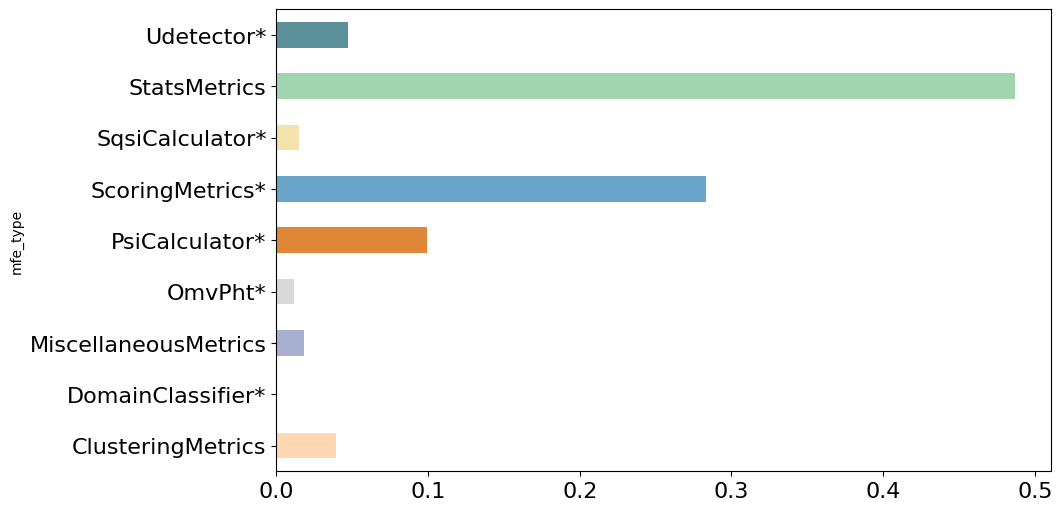

In [232]:
plot_bars(all_imps, color=COLORS)

In [233]:
def plot_imp_bars(importances: pd.DataFrame, groupby: str="dataset", hue: str="proposed_mfe", sort_values=None):
    importances = importances.copy()
    importances["dataset"] = importances["dataset"].apply(lambda x: x.replace(".csv", "").replace("_", " "))
    importances["proposed_mfe"] = importances["proposed_mfe"].apply(lambda x: "Proposed MFE" if x==True else "Literature MFE")

    total_imp_dict = importances[["dataset", "importance"]].groupby([groupby]).sum().to_dict()["importance"]
    dataset_df = importances[[groupby, hue, "importance"]].groupby([groupby, hue]).sum().reset_index()
    dataset_df["importance"] = dataset_df.apply(lambda  x: x["importance"]/total_imp_dict[x[groupby]], axis=1)
    dataset_df = dataset_df.pivot(index=groupby, columns=hue)
    dataset_df.columns = dataset_df.columns.droplevel()
    
    if sort_values:
        dataset_df = dataset_df.sort_values(**sort_values)
    dataset_df.plot.barh(figsize=(7, 10), fontsize=16, color=COLORS, stacked=True).legend(loc='best', prop={'size': 16}, bbox_to_anchor=(1.65, 0.8))

# Mean importance per dataset with Kappa

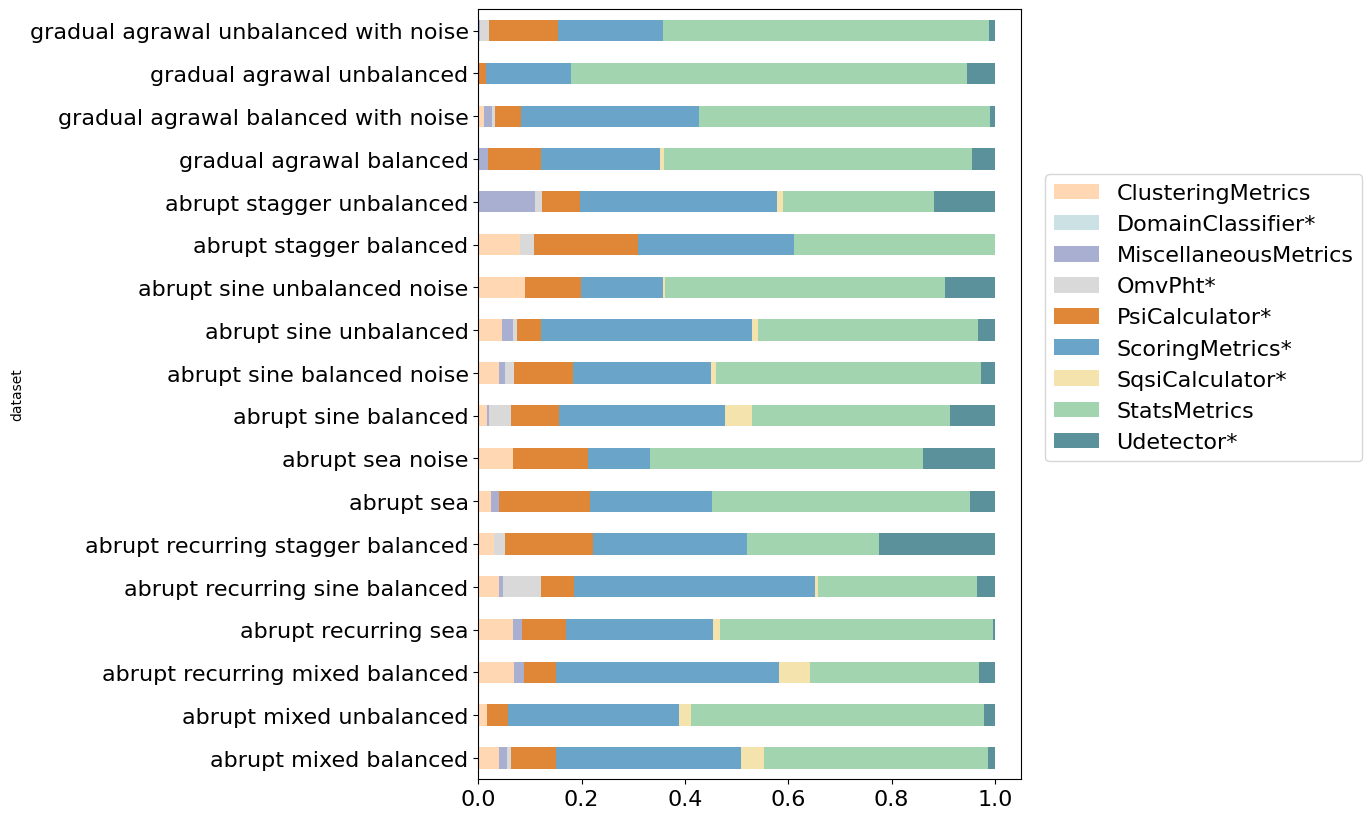

In [234]:
specific_df = all_imps[all_imps["meta_label"] == "kappa"]
plot_imp_bars(specific_df, groupby="dataset", hue="mfe_type")

## Mean importance per dataset (considering all base models and metrics)

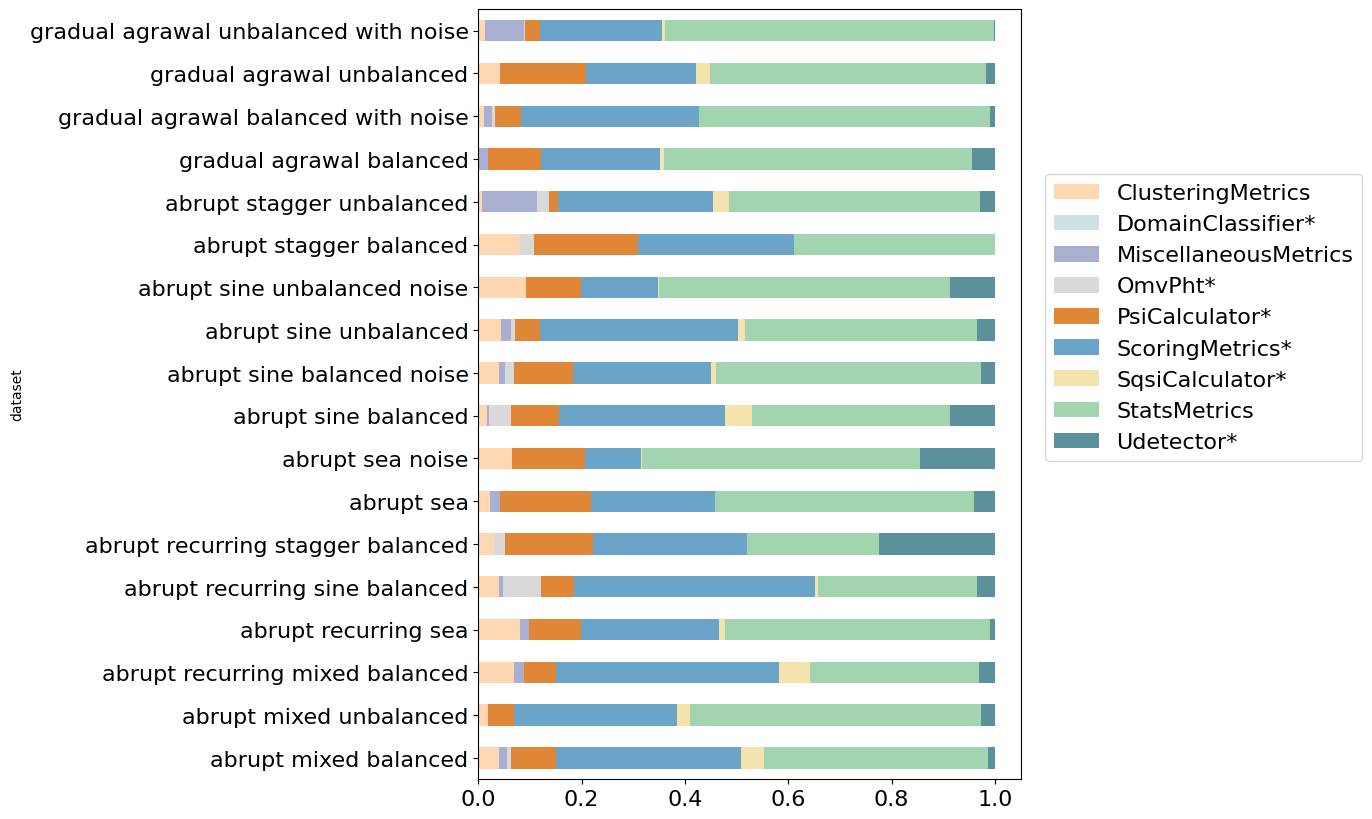

In [235]:
plot_imp_bars(all_imps, groupby="dataset", hue="mfe_type")

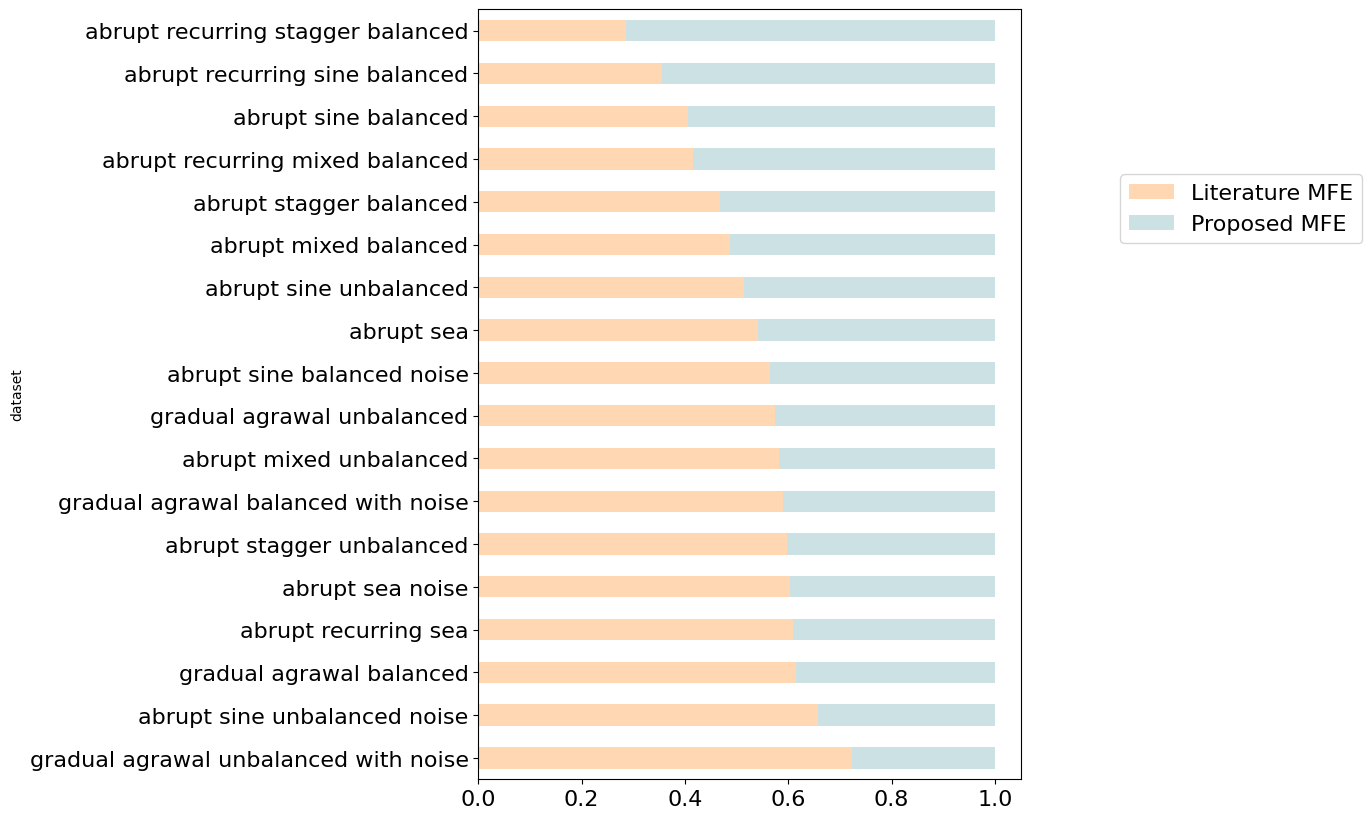

In [236]:
plot_imp_bars(all_imps, sort_values={"by": "Proposed MFE", "ascending": True})

In [237]:
all_imps.sort_values(by="importance", ascending=False)

,feature,importance,meta_label,base_model,dataset,mfe_type,proposed_mfe
18196,salary_mean,1.0,precision,SVC,gradual_agrawal_balanced_with_noise.csv,StatsMetrics,False
2071,psi_2,1.0,f1-score,RandomForestClassifier,abrupt_sea.csv,PsiCalculator*,True
17920,kmeans_inertia,1.0,f1-score,SVC,gradual_agrawal_unbalanced.csv,ClusteringMetrics,False
1972,psi_2,1.0,recall,RandomForestClassifier,abrupt_sea.csv,PsiCalculator*,True
4676,1_max,1.0,f1-score,RandomForestClassifier,abrupt_sea_noise.csv,StatsMetrics,False
...,...,...,...,...,...,...,...
14334,0_std,0.0,kappa,SVC,abrupt_sea_noise.csv,StatsMetrics,False
14333,0_mean,0.0,kappa,SVC,abrupt_sea_noise.csv,StatsMetrics,False
14332,sqsi_drift_flag,0.0,kappa,SVC,abrupt_sea_noise.csv,SqsiCalculator*,True
14331,predict_proba_1_ks_pvalue,0.0,kappa,SVC,abrupt_sea_noise.csv,SqsiCalculator*,True
